<a href="https://colab.research.google.com/github/naenumtou/ifrs9/blob/main/PD/BayesCalibration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Set auto reload
%reload_ext autoreload
%autoreload 2

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import warnings

from scipy.special import logit, expit
from scipy.optimize import minimize

# Config
%config InlineBackend.figure_format = 'retina' #Retina display
warnings.filterwarnings('ignore') #Disable warning
plt.style.use('seaborn-deep') #Plot style

In [3]:
# Define plot matrix function
def plotMatrix(data, plotName, format = True):
  if format is True:
    fmtType = '.2%'
  else:
    fmtType = '.4g'
  plt.figure(figsize = (14, 9))
  plt.title(f'{plotName}')
  ax = sns.heatmap(
      data,
      annot = True,
      fmt = fmtType,
      xticklabels = True,
      yticklabels = True,
      cmap = 'RdYlGn_r',
      cbar = False
  )
  ax.xaxis.tick_top() #x-axis on top
  ax.xaxis.set_label_position('top')
  return plt.show()

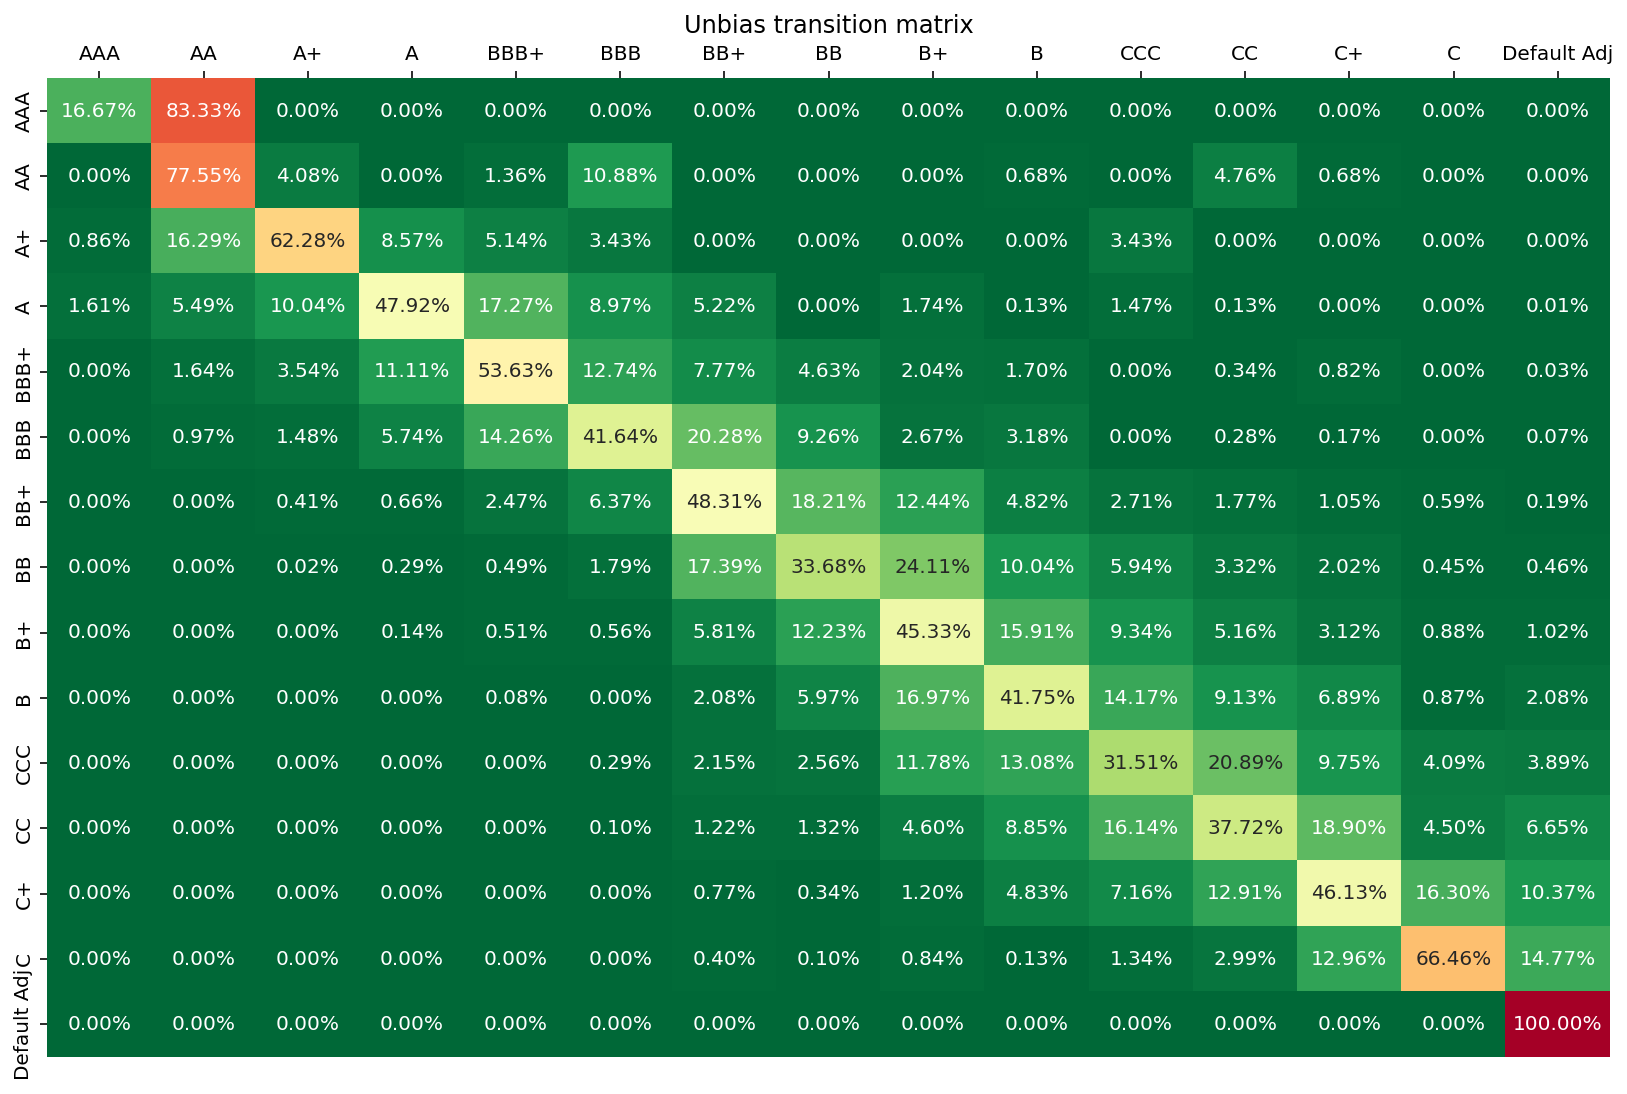

In [4]:
# Import dataset of transition matrix
df = pd.read_csv(
    'https://raw.githubusercontent.com/naenumtou/ifrs9/main/PD/datasets/matrixAdjustment.csv'
)

# Assign index to be the same as columns
df.index = df.columns[:-1]

# Plot
plotMatrix(df.iloc[:, :-1], 'Unbias transition matrix')

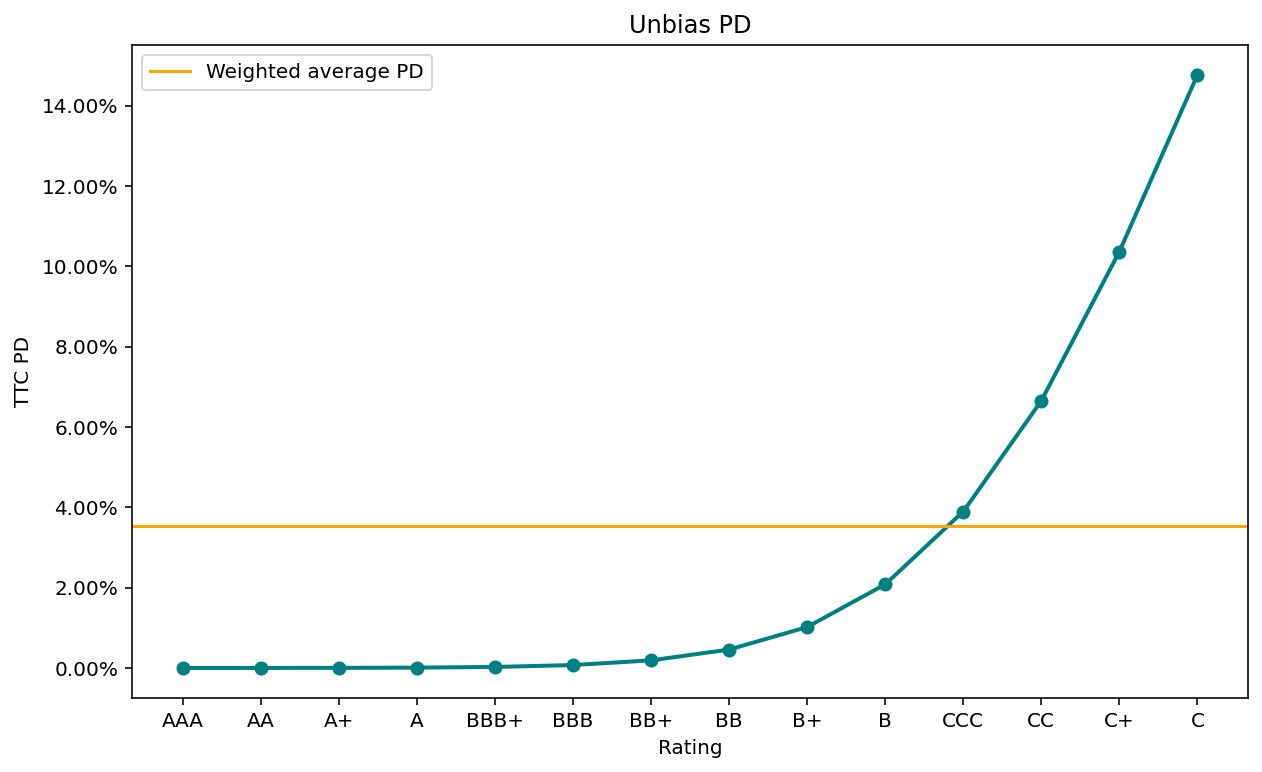

In [5]:
# TTC PD
ttc = df['Default Adj'].iloc[:-1] #Without default row

# Weighted average
average = np.average(
    ttc,
    weights = df['N'].iloc[:-1],
    axis = 0
)

# Plot
plt.figure(figsize = (10, 6))
plt.plot(
    ttc,
    color = 'teal',
    linewidth = 2,
    marker = 'o'
)
plt.axhline(
    y = average,
    c = 'orange',
    label = 'Weighted average PD'
)
plt.gca().set_yticklabels([f'{y * 100:.2f}%' for y in plt.gca().get_yticks()])
plt.legend(
    frameon = True,
    facecolor = 'white'
)
plt.ylabel('TTC PD')
plt.xlabel('Rating')
plt.title('Unbias PD')
plt.show()

### Scaling method
For portfolio where the existing internal rating model can be leveraged on, the scaling method of the internal rating PD to match with the predicted PD from the forward-looking model.

The followings are the step to perform PD Calibration by scaling method:
- Compute the predicted PD by applying the forecasted macroeconomic figures into the model estimated
- Convert the internal rating PD to logit scale. The logit is the natural log of odds of a function, which is typically represented as:

\begin{align}
        Logit_{PD} = \ln\left(\frac{PD}{1 - PD}\right)
    \end{align}

- Upon obtaining the internal rating PD logit and multiply with the base scale number
- Compute the corresponding PiT PD from the logit PiT PD
- Obtain a weighted average of the predicted internal rating PD by weighting the corresponding PD buckets by the distribution of number of customers for the unbias model
- Optimize the scale number that the weighted average PiT PD is the same with the predicted portfolio PD from the forward-looking model

In [6]:
# Assume the forward-looking PD
FWLPD = 0.047

# Scaling method
# Define scaling function
def fittingPD(x):
  logitTTC = logit(ttc)
  scaledPD = expit(logitTTC * x) #Apply scaling factor and convert back to PD
  scaledPDAvg = np.average(
      scaledPD,
      weights = df['N'].iloc[:-1],
      axis = 0
  ) #Weighted average
  return np.abs(FWLPD - scaledPDAvg)

# Define minimise error function
def findScalar(x):
  return fittingPD(x)

In [7]:
# Initial guess
init = [0.00001]

# Finding scalar
scalarOpt = minimize(findScalar, init)
scalarOpt

      fun: 8.610504809158925e-10
 hess_inv: array([[6.44691017e-08]])
      jac: array([-9.31322575e-10])
  message: 'Optimization terminated successfully.'
     nfev: 84
      nit: 4
     njev: 28
   status: 0
  success: True
        x: array([0.88120594])

In [8]:
# Scalar result
scalar = scalarOpt.x[0]
print(f'Scaling factor: {scalar:.4f}')

Scaling factor: 0.8812


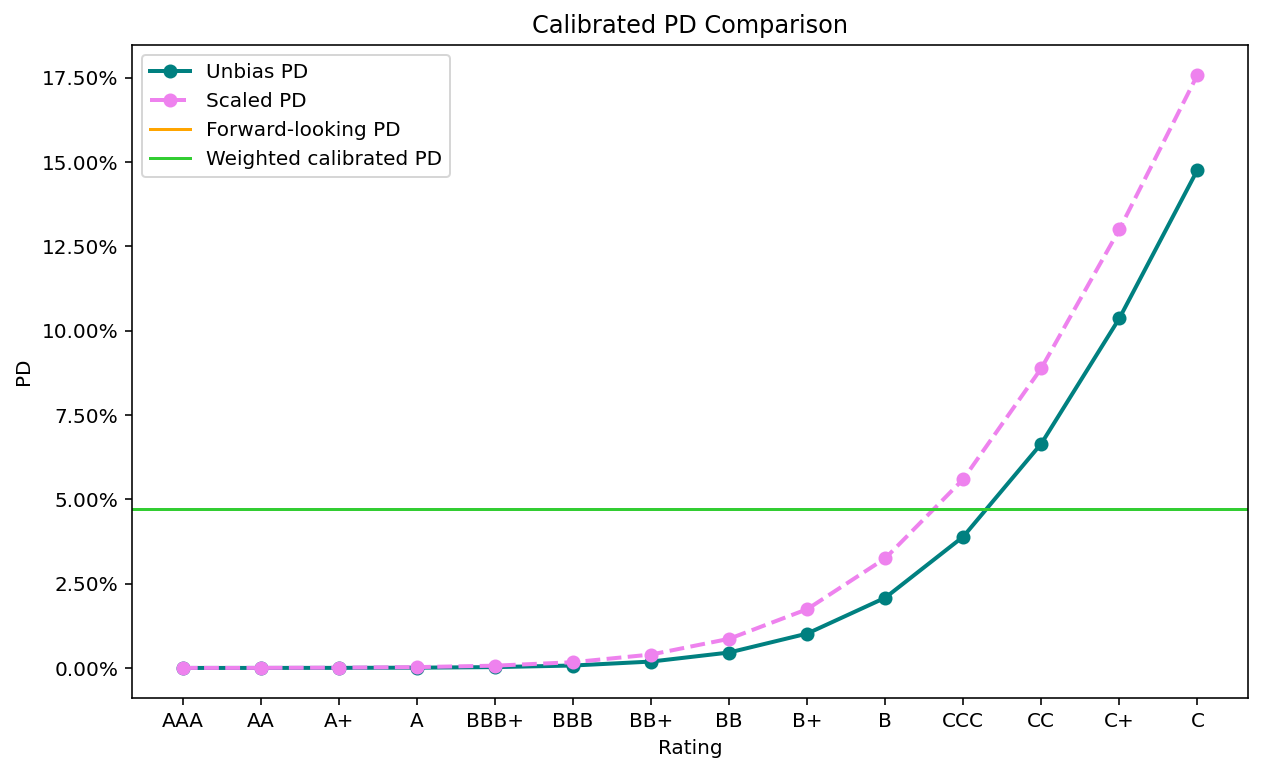

In [9]:
# Apply scaling factor
scaledPD = expit(
    logit(ttc) * scalar
)

# Weighted average
scaledPDAvg = np.average(
    scaledPD,
    weights = df['N'].iloc[:-1],
    axis = 0
)

# Plot
plt.figure(figsize = (10, 6))
plt.plot(
    ttc,
    color = 'teal',
    linewidth = 2,
    marker = 'o',
    label = 'Unbias PD'
)
plt.plot(
    scaledPD,
    color = 'violet',
    linewidth = 2,
    linestyle = '--',
    marker = 'o',
    label = 'Scaled PD'
)
plt.axhline(
    y = FWLPD,
    c = 'orange',
    label = 'Forward-looking PD'
)
plt.axhline(
    y = scaledPDAvg,
    c = 'limegreen',
    label = 'Weighted calibrated PD'
)
plt.gca().set_yticklabels([f'{y * 100:.2f}%' for y in plt.gca().get_yticks()])
plt.legend(
    frameon = True,
    facecolor = 'white'
)
plt.ylabel('PD')
plt.xlabel('Rating')
plt.title('Calibrated PD Comparison')
plt.show()

### Bayes formula
The concept of calibration is to adjust the probability of default estimates so that, on average, the default rates will not deviate from the long-run average of the historical default rates or unbias default rates.

The Bayes formula can be found below:

\begin{align}
        PD_{i}^{PiT} = \frac{(1 - PD_{TTC}) * PD_{PiT} * PD_{i}^{TTC}}{PD_{TTC} * (1 - PD_{PiT}) * (1 - PD_{i}^{TTC}) + (1 - PD_{TTC}) * PD_{PiT} * PD_{i}^{TTC}}
    \end{align}

where;
- $PD_{TTC}$ is the overall portfolio TTC Default rate (Unbias PD)
- $PD_{PiT}$ is the predicted PD from the macroeconomics model
- $PD_{i}^{TTC}$ is the default rate of the corresponding PD buckets

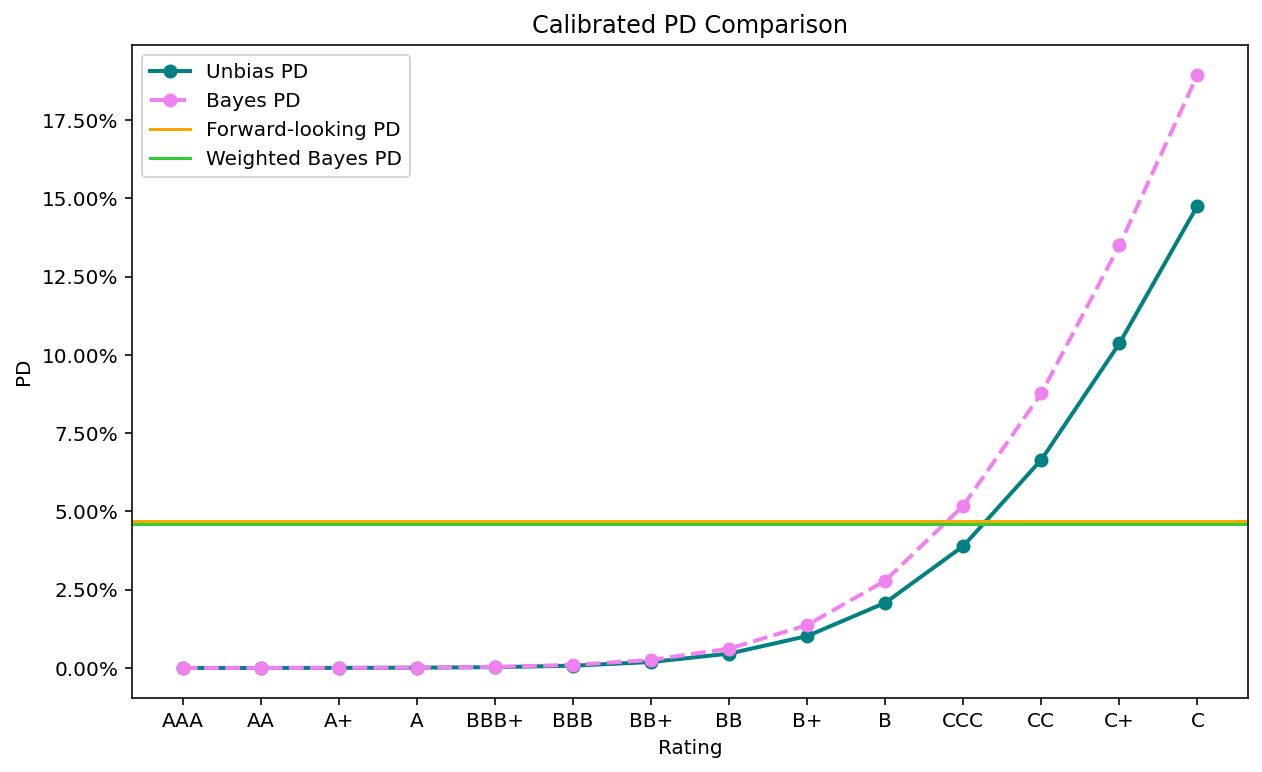

In [10]:
# Bayes formula
BayPD = ((1 - average) * FWLPD * ttc) / \
        (average * (1 - FWLPD) * (1 - ttc) + (1 - average) * FWLPD * ttc)

# Weighted average
BayPDAvg = np.average(
    BayPD,
    weights = df['N'].iloc[:-1],
    axis = 0
)

# Plot
plt.figure(figsize = (10, 6))
plt.plot(
    ttc,
    color = 'teal',
    linewidth = 2,
    marker = 'o',
    label = 'Unbias PD'
)
plt.plot(
    BayPD,
    color = 'violet',
    linewidth = 2,
    linestyle = '--',
    marker = 'o',
    label = 'Bayes PD'
)
plt.axhline(
    y = FWLPD,
    c = 'orange',
    label = 'Forward-looking PD'
)
plt.axhline(
    y = BayPDAvg,
    c = 'limegreen',
    label = 'Weighted Bayes PD'
)
plt.gca().set_yticklabels([f'{y * 100:.2f}%' for y in plt.gca().get_yticks()])
plt.legend(
    frameon = True,
    facecolor = 'white'
)
plt.ylabel('PD')
plt.xlabel('Rating')
plt.title('Calibrated PD Comparison')
plt.show()

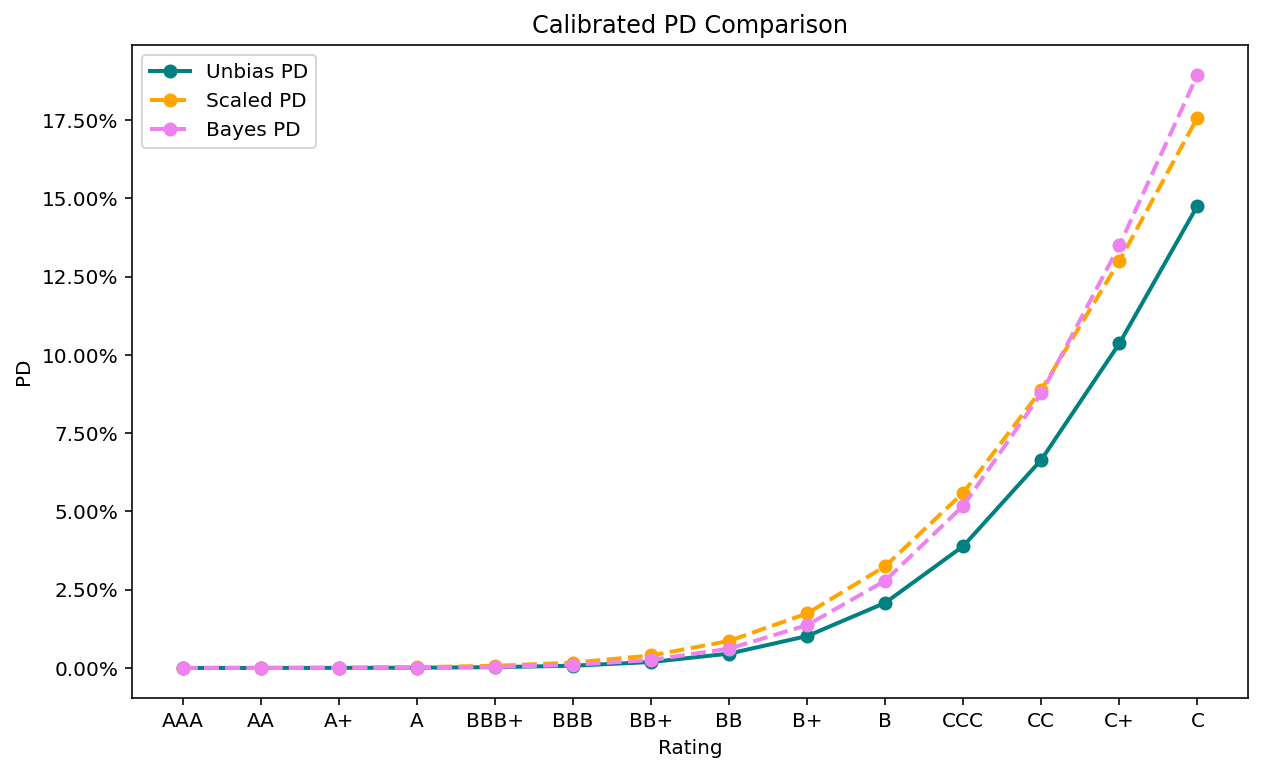

In [11]:
# Plot comparison
plt.figure(figsize = (10, 6))
plt.plot(
    ttc,
    color = 'teal',
    linewidth = 2,
    marker = 'o',
    label = 'Unbias PD'
)
plt.plot(
    scaledPD,
    color = 'orange',
    linewidth = 2,
    linestyle = '--',
    marker = 'o',
    label = 'Scaled PD'
)
plt.plot(
    BayPD,
    color = 'violet',
    linewidth = 2,
    linestyle = '--',
    marker = 'o',
    label = 'Bayes PD'
)
plt.gca().set_yticklabels([f'{y * 100:.2f}%' for y in plt.gca().get_yticks()])
plt.legend(
    frameon = True,
    facecolor = 'white'
)
plt.ylabel('PD')
plt.xlabel('Rating')
plt.title('Calibrated PD Comparison')
plt.show()